## 1. Import Required Libraries

## Quick Start - Load Pre-trained Models

**If you've already trained the models once**, just run the cells below to load them instantly without retraining. Otherwise, run all cells from the beginning to train and save the models.

In [1]:
# ========================================
# QUICK LOAD - Run this cell to use pre-trained models
# ========================================
import joblib
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download NLTK resources
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)

# Define preprocessing function (needed for predictions)
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    """Preprocess text for sentiment analysis."""
    text = text.lower()
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    return ' '.join(tokens)

def predict_sentiment(text, model, vectorizer):
    """Predict sentiment for a new text review."""
    cleaned_text = preprocess_text(text)
    text_vectorized = vectorizer.transform([cleaned_text])
    prediction = model.predict(text_vectorized)[0]
    return "Positive" if prediction == 1 else "Negative"

# Load saved models if they exist
models_dir = 'saved_models'

if os.path.exists(models_dir):
    print("Loading pre-trained models...")
    best_model_obj = joblib.load(f'{models_dir}/best_model.joblib')
    best_vectorizer = joblib.load(f'{models_dir}/tfidf_vectorizer.joblib')
    print("✓ Models loaded successfully! You can now use analyze_sentiment() directly.")
    
    def analyze_sentiment(review_text):
        """Analyze sentiment of any text you provide."""
        sentiment = predict_sentiment(review_text, best_model_obj, best_vectorizer)
        print(f"\n{'='*60}")
        print("YOUR REVIEW:")
        print(f"  \"{review_text}\"")
        print(f"\nPREDICTED SENTIMENT: {sentiment}")
        print(f"{'='*60}")
        return sentiment
else:
    print("⚠ No saved models found!")
    print("Please run all cells below to train and save the models first.")

Loading pre-trained models...
✓ Models loaded successfully! You can now use analyze_sentiment() directly.


In [3]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Text preprocessing
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Feature extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Machine Learning models
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

# Model evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

print("All libraries imported successfully!")

All libraries imported successfully!


## 2. Load and Explore the Dataset

In [5]:
# Load the IMDb dataset
# The dataset should be in the data folder as 'imdb_reviews.csv'
# with columns: 'review' (text) and 'sentiment' (positive/negative)

try:
    df = pd.read_csv('data/imdb_reviews.csv')
    print("Dataset loaded successfully from local file!")
except FileNotFoundError:
    # If local file not found, create a fallback dataset
    # Download the full dataset from: https://ai.stanford.edu/~amaas/data/sentiment/
    print("Local dataset not found. Creating fallback dataset...")
    
    # Create fallback data for initial testing
    sample_reviews = [
        # Positive reviews
        ("This movie was absolutely fantastic! The acting was superb and the plot kept me engaged throughout.", "positive"),
        ("I loved every minute of this film. Great performances and beautiful cinematography.", "positive"),
        ("An excellent movie that exceeded all my expectations. Highly recommended!", "positive"),
        ("Brilliant storytelling and amazing character development. A must-watch!", "positive"),
        ("One of the best movies I've seen this year. Truly a masterpiece.", "positive"),
        ("The director did an outstanding job. Every scene was perfect.", "positive"),
        ("Absolutely loved it! The soundtrack was amazing and the visuals stunning.", "positive"),
        ("A wonderful movie with great emotional depth. I was moved to tears.", "positive"),
        ("Fantastic film with excellent performances from the entire cast.", "positive"),
        ("This is cinema at its finest. Beautiful, touching, and unforgettable.", "positive"),
        # Negative reviews
        ("This movie was terrible. I couldn't wait for it to end.", "negative"),
        ("Waste of time and money. The plot made no sense at all.", "negative"),
        ("Boring and predictable. I fell asleep halfway through.", "negative"),
        ("The acting was awful and the story was completely unoriginal.", "negative"),
        ("One of the worst movies I've ever seen. Avoid at all costs.", "negative"),
        ("Disappointing film with poor direction and weak performances.", "negative"),
        ("I regret watching this. It was painfully slow and uninteresting.", "negative"),
        ("Terrible movie with no redeeming qualities whatsoever.", "negative"),
        ("A complete disaster from start to finish. Save your money.", "negative"),
        ("Awful script and even worse acting. A total disappointment.", "negative"),
    ]
    
    # Expand the sample data to have more examples for training
    expanded_data = sample_reviews * 100  # Create 2000 samples
    
    df = pd.DataFrame(expanded_data, columns=['review', 'sentiment'])
    print(f"Sample dataset created with {len(df)} reviews.")

# Display basic information
print(f"\nDataset Shape: {df.shape}")
print(f"\nColumn Names: {df.columns.tolist()}")

Dataset loaded successfully from local file!

Dataset Shape: (50000, 2)

Column Names: ['review', 'sentiment']


In [6]:
# Display first few rows of the dataset
print("First 5 rows of the dataset:")
df.head()

First 5 rows of the dataset:


,review,sentiment
0,"When I first saw the ad for this, I was like '...",positive
1,"""A Girl's Folly"" is a sort of half-comedy, hal...",positive
2,I started watching the show from the first sea...,positive
3,This is a more interesting than usual porn mov...,positive
4,I suppose for 1961 this film was supposed to b...,negative


In [7]:
# Check for missing values
print("Missing Values:")
print(df.isnull().sum())

# Dataset statistics
print("\nDataset Info:")
df.info()

Missing Values:
review       0
sentiment    0
dtype: int64

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


Sentiment Distribution:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


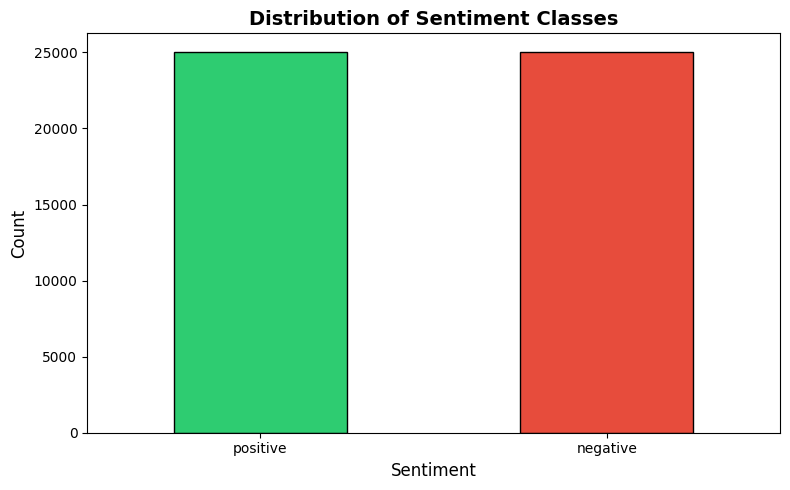

In [8]:
# Check class distribution
print("Sentiment Distribution:")
print(df['sentiment'].value_counts())

# Visualize class distribution
plt.figure(figsize=(8, 5))
colors = ['#2ecc71', '#e74c3c']
df['sentiment'].value_counts().plot(kind='bar', color=colors, edgecolor='black')
plt.title('Distribution of Sentiment Classes', fontsize=14, fontweight='bold')
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## 3. Text Preprocessing

Text preprocessing is a crucial step in NLP. We will:
1. Convert text to lowercase
2. Remove punctuation and special characters
3. Remove stop words using NLTK
4. Tokenize text data

In [9]:
# Download NLTK resources (if not already downloaded)
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)

# Get English stop words
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    """
    Preprocess text by:
    1. Converting to lowercase
    2. Removing punctuation and special characters
    3. Removing stop words
    4. Tokenizing and rejoining
    
    Args:
        text (str): Input text to preprocess
    
    Returns:
        str: Preprocessed text
    """
    # Convert to lowercase
    text = text.lower()
    
    # Remove HTML tags (common in web scraped data)
    text = re.sub(r'<[^>]+>', '', text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    
    # Remove punctuation and special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize text
    tokens = word_tokenize(text)
    
    # Remove stop words and keep only words with length > 2
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    
    # Rejoin tokens
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text

print("Preprocessing function defined successfully!")

Preprocessing function defined successfully!


In [10]:
# Apply preprocessing to all reviews
print("Preprocessing reviews... This may take a moment.")
df['cleaned_review'] = df['review'].apply(preprocess_text)
print("Preprocessing complete!")

# Display sample of original vs cleaned text
print("\n" + "="*80)
print("COMPARISON: Original vs Preprocessed Text")
print("="*80)

for i in range(3):
    print(f"\n--- Example {i+1} ---")
    print(f"Original: {df['review'].iloc[i][:100]}...")
    print(f"Cleaned:  {df['cleaned_review'].iloc[i][:100]}...")

Preprocessing reviews... This may take a moment.
Preprocessing complete!

COMPARISON: Original vs Preprocessed Text

--- Example 1 ---
Original: When I first saw the ad for this, I was like 'Oh here we go. He's done High School Musical, but he c...
Cleaned:  first saw like hes done high school musical cant coast along hes making appearances disney shows per...

--- Example 2 ---
Original: "A Girl's Folly" is a sort of half-comedy, half-mockumentary look at the motion picture business of ...
Cleaned:  girls folly sort halfcomedy halfmockumentary look motion picture business mids get glimpse life earl...

--- Example 3 ---
Original: I started watching the show from the first season, and at the beginning I was pretty skeptical about...
Cleaned:  started watching show first season beginning pretty skeptical original movie kind childish looking s...


In [11]:
# Convert sentiment labels to binary (0 for negative, 1 for positive)
df['sentiment_label'] = df['sentiment'].map({'positive': 1, 'negative': 0})

print("Sentiment labels converted to binary format:")
print(df[['sentiment', 'sentiment_label']].drop_duplicates())

Sentiment labels converted to binary format:
  sentiment  sentiment_label
0  positive                1
4  negative                0


## 4. Feature Extraction

We will use two feature extraction techniques:
1. **Bag of Words (BoW)**: Counts the frequency of each word in the document
2. **TF-IDF (Term Frequency-Inverse Document Frequency)**: Weights words based on their importance

In [12]:
# Split data into features (X) and target (y)
X = df['cleaned_review']
y = df['sentiment_label']

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y  # Ensure balanced split
)

print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")
print(f"\nTraining set class distribution:\n{y_train.value_counts()}")
print(f"\nTesting set class distribution:\n{y_test.value_counts()}")

Training set size: 40000
Testing set size: 10000

Training set class distribution:
sentiment_label
1    20000
0    20000
Name: count, dtype: int64

Testing set class distribution:
sentiment_label
0    5000
1    5000
Name: count, dtype: int64


In [13]:
# Initialize Bag of Words Vectorizer
bow_vectorizer = CountVectorizer(
    max_features=5000,  # Limit vocabulary size
    ngram_range=(1, 2)  # Include unigrams and bigrams
)

# Fit and transform training data, transform test data
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

print("Bag of Words Feature Extraction:")
print(f"Training features shape: {X_train_bow.shape}")
print(f"Testing features shape: {X_test_bow.shape}")
print(f"Vocabulary size: {len(bow_vectorizer.vocabulary_)}")

Bag of Words Feature Extraction:
Training features shape: (40000, 5000)
Testing features shape: (10000, 5000)
Vocabulary size: 5000


In [14]:
# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,  # Limit vocabulary size
    ngram_range=(1, 2)  # Include unigrams and bigrams
)

# Fit and transform training data, transform test data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print("TF-IDF Feature Extraction:")
print(f"Training features shape: {X_train_tfidf.shape}")
print(f"Testing features shape: {X_test_tfidf.shape}")
print(f"Vocabulary size: {len(tfidf_vectorizer.vocabulary_)}")

TF-IDF Feature Extraction:
Training features shape: (40000, 5000)
Testing features shape: (10000, 5000)
Vocabulary size: 5000


## 5. Model Training and Evaluation

We will train and evaluate three machine learning models:
1. Naive Bayes
2. Logistic Regression
3. Support Vector Machine (SVM)

In [15]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """
    Train a model and evaluate its performance.
    
    Args:
        model: Machine learning model to train
        X_train: Training features
        X_test: Testing features
        y_train: Training labels
        y_test: Testing labels
        model_name: Name of the model for display
    
    Returns:
        dict: Dictionary containing evaluation metrics
    """
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Print results
    print(f"\n{'='*60}")
    print(f"{model_name} Results")
    print(f"{'='*60}")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))
    
    return {
        'model_name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': conf_matrix
    }

print("Evaluation function defined successfully!")

Evaluation function defined successfully!


In [16]:
def plot_confusion_matrix(conf_matrix, model_name):
    """
    Plot a confusion matrix heatmap.
    
    Args:
        conf_matrix: Confusion matrix array
        model_name: Name of the model for the title
    """
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        conf_matrix, 
        annot=True, 
        fmt='d', 
        cmap='Blues',
        xticklabels=['Negative', 'Positive'],
        yticklabels=['Negative', 'Positive']
    )
    plt.title(f'Confusion Matrix - {model_name}', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('Actual', fontsize=12)
    plt.tight_layout()
    plt.show()

print("Confusion matrix plotting function defined successfully!")

Confusion matrix plotting function defined successfully!


### 5.1 Naive Bayes Classifier

Naive Bayes is a probabilistic classifier based on Bayes' theorem. It works well with text classification tasks and is particularly effective with Bag of Words features.


Naive Bayes (BoW) Results
Accuracy:  0.8499
Precision: 0.8469
Recall:    0.8542
F1-Score:  0.8505

Classification Report:
              precision    recall  f1-score   support

    Negative       0.85      0.85      0.85      5000
    Positive       0.85      0.85      0.85      5000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



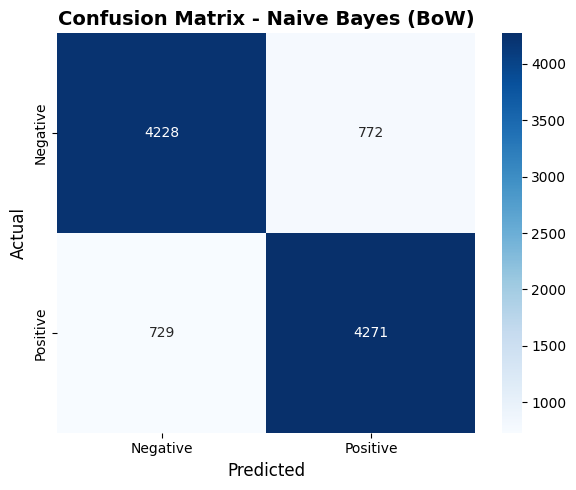

In [17]:
# Train and evaluate Naive Bayes with Bag of Words
nb_model_bow = MultinomialNB()
nb_bow_results = evaluate_model(
    nb_model_bow, 
    X_train_bow, X_test_bow, 
    y_train, y_test, 
    "Naive Bayes (BoW)"
)
plot_confusion_matrix(nb_bow_results['confusion_matrix'], "Naive Bayes (BoW)")


Naive Bayes (TF-IDF) Results
Accuracy:  0.8586
Precision: 0.8496
Recall:    0.8714
F1-Score:  0.8604

Classification Report:
              precision    recall  f1-score   support

    Negative       0.87      0.85      0.86      5000
    Positive       0.85      0.87      0.86      5000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



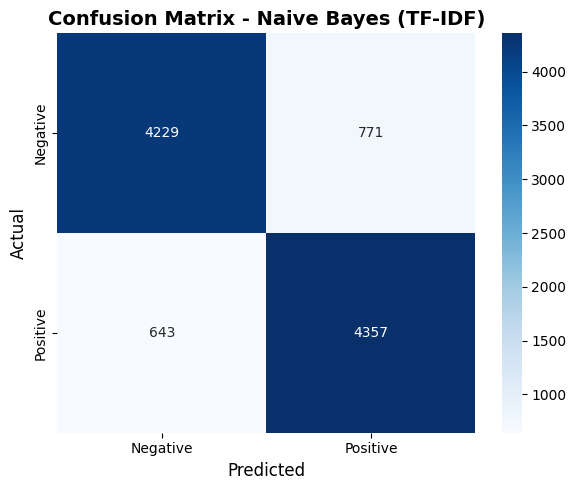

In [18]:
# Train and evaluate Naive Bayes with TF-IDF
nb_model_tfidf = MultinomialNB()
nb_tfidf_results = evaluate_model(
    nb_model_tfidf, 
    X_train_tfidf, X_test_tfidf, 
    y_train, y_test, 
    "Naive Bayes (TF-IDF)"
)
plot_confusion_matrix(nb_tfidf_results['confusion_matrix'], "Naive Bayes (TF-IDF)")

### 5.2 Logistic Regression

Logistic Regression is a linear classifier that predicts the probability of a binary outcome. It's widely used for text classification due to its efficiency and interpretability.


Logistic Regression (BoW) Results
Accuracy:  0.8702
Precision: 0.8658
Recall:    0.8762
F1-Score:  0.8710

Classification Report:
              precision    recall  f1-score   support

    Negative       0.87      0.86      0.87      5000
    Positive       0.87      0.88      0.87      5000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



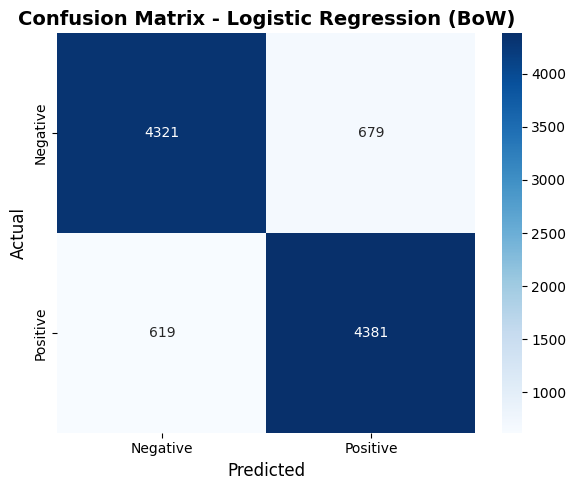

In [19]:
# Train and evaluate Logistic Regression with Bag of Words
lr_model_bow = LogisticRegression(max_iter=1000, random_state=42)
lr_bow_results = evaluate_model(
    lr_model_bow, 
    X_train_bow, X_test_bow, 
    y_train, y_test, 
    "Logistic Regression (BoW)"
)
plot_confusion_matrix(lr_bow_results['confusion_matrix'], "Logistic Regression (BoW)")


Logistic Regression (TF-IDF) Results
Accuracy:  0.8873
Precision: 0.8811
Recall:    0.8954
F1-Score:  0.8882

Classification Report:
              precision    recall  f1-score   support

    Negative       0.89      0.88      0.89      5000
    Positive       0.88      0.90      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



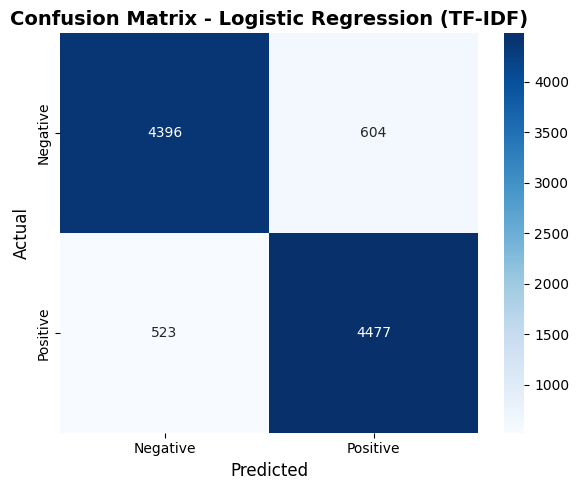

In [20]:
# Train and evaluate Logistic Regression with TF-IDF
lr_model_tfidf = LogisticRegression(max_iter=1000, random_state=42)
lr_tfidf_results = evaluate_model(
    lr_model_tfidf, 
    X_train_tfidf, X_test_tfidf, 
    y_train, y_test, 
    "Logistic Regression (TF-IDF)"
)
plot_confusion_matrix(lr_tfidf_results['confusion_matrix'], "Logistic Regression (TF-IDF)")

### 5.3 Support Vector Machine (SVM)

Support Vector Machine finds the optimal hyperplane that separates classes with maximum margin. LinearSVC is used for efficiency with high-dimensional text data.


SVM (BoW) Results
Accuracy:  0.8637
Precision: 0.8623
Recall:    0.8656
F1-Score:  0.8640

Classification Report:
              precision    recall  f1-score   support

    Negative       0.87      0.86      0.86      5000
    Positive       0.86      0.87      0.86      5000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



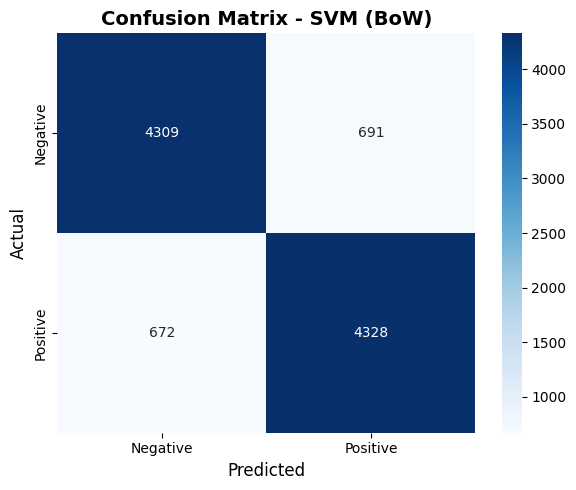

In [21]:
# Train and evaluate SVM with Bag of Words
svm_model_bow = LinearSVC(random_state=42, max_iter=1000)
svm_bow_results = evaluate_model(
    svm_model_bow, 
    X_train_bow, X_test_bow, 
    y_train, y_test, 
    "SVM (BoW)"
)
plot_confusion_matrix(svm_bow_results['confusion_matrix'], "SVM (BoW)")


SVM (TF-IDF) Results
Accuracy:  0.8789
Precision: 0.8724
Recall:    0.8876
F1-Score:  0.8799

Classification Report:
              precision    recall  f1-score   support

    Negative       0.89      0.87      0.88      5000
    Positive       0.87      0.89      0.88      5000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



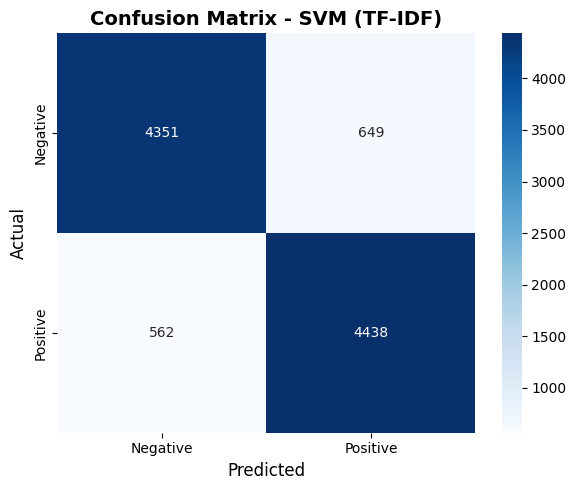

In [22]:
# Train and evaluate SVM with TF-IDF
svm_model_tfidf = LinearSVC(random_state=42, max_iter=1000)
svm_tfidf_results = evaluate_model(
    svm_model_tfidf, 
    X_train_tfidf, X_test_tfidf, 
    y_train, y_test, 
    "SVM (TF-IDF)"
)
plot_confusion_matrix(svm_tfidf_results['confusion_matrix'], "SVM (TF-IDF)")

## 6. Model Comparison

Let's create a comprehensive comparison table showing the performance of all models.

In [23]:
# Collect all results
all_results = [
    nb_bow_results,
    nb_tfidf_results,
    lr_bow_results,
    lr_tfidf_results,
    svm_bow_results,
    svm_tfidf_results
]

# Create comparison DataFrame
comparison_data = {
    'Model': [r['model_name'] for r in all_results],
    'Accuracy': [f"{r['accuracy']:.4f}" for r in all_results],
    'Precision': [f"{r['precision']:.4f}" for r in all_results],
    'Recall': [f"{r['recall']:.4f}" for r in all_results],
    'F1-Score': [f"{r['f1_score']:.4f}" for r in all_results]
}

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*80)
print("MODEL PERFORMANCE COMPARISON TABLE")
print("="*80)
print(comparison_df.to_string(index=False))


MODEL PERFORMANCE COMPARISON TABLE
                       Model Accuracy Precision Recall F1-Score
           Naive Bayes (BoW)   0.8499    0.8469 0.8542   0.8505
        Naive Bayes (TF-IDF)   0.8586    0.8496 0.8714   0.8604
   Logistic Regression (BoW)   0.8702    0.8658 0.8762   0.8710
Logistic Regression (TF-IDF)   0.8873    0.8811 0.8954   0.8882
                   SVM (BoW)   0.8637    0.8623 0.8656   0.8640
                SVM (TF-IDF)   0.8789    0.8724 0.8876   0.8799


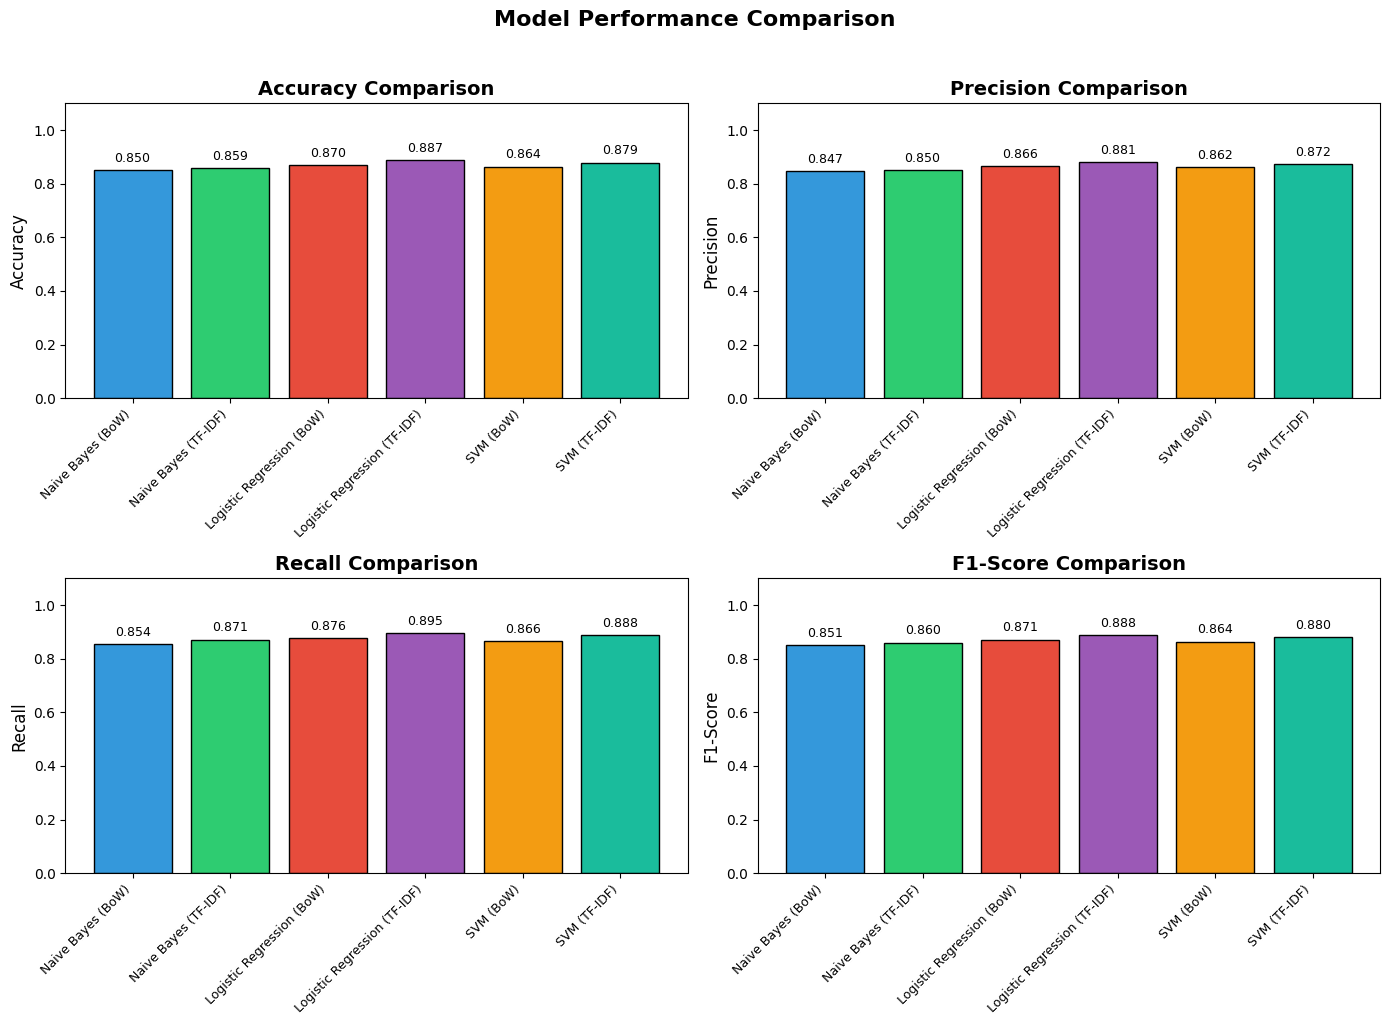

In [24]:
# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6', '#f39c12', '#1abc9c']

for ax, metric in zip(axes.flatten(), metrics):
    values = [float(comparison_df[metric].iloc[i]) for i in range(len(comparison_df))]
    models = comparison_df['Model'].tolist()
    
    bars = ax.bar(range(len(models)), values, color=colors, edgecolor='black')
    ax.set_title(f'{metric} Comparison', fontsize=14, fontweight='bold')
    ax.set_ylabel(metric, fontsize=12)
    ax.set_xticks(range(len(models)))
    ax.set_xticklabels(models, rotation=45, ha='right', fontsize=9)
    ax.set_ylim(0, 1.1)
    
    # Add value labels on bars
    for bar, val in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                f'{val:.3f}', ha='center', va='bottom', fontsize=9)

plt.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [25]:
# Find the best performing model
best_idx = comparison_df['F1-Score'].astype(float).idxmax()
best_model = comparison_df.iloc[best_idx]

print("\n" + "="*60)
print("BEST PERFORMING MODEL")
print("="*60)
print(f"Model: {best_model['Model']}")
print(f"Accuracy: {best_model['Accuracy']}")
print(f"Precision: {best_model['Precision']}")
print(f"Recall: {best_model['Recall']}")
print(f"F1-Score: {best_model['F1-Score']}")


BEST PERFORMING MODEL
Model: Logistic Regression (TF-IDF)
Accuracy: 0.8873
Precision: 0.8811
Recall: 0.8954
F1-Score: 0.8882


In [26]:
# ========================================
# SAVE TRAINED MODELS
# ========================================
# This saves the models so you can load them later without retraining

import joblib
import os

# Create directory for saved models
models_dir = 'saved_models'
os.makedirs(models_dir, exist_ok=True)

# Save the best model (Logistic Regression with TF-IDF)
joblib.dump(lr_model_tfidf, f'{models_dir}/best_model.joblib')
joblib.dump(tfidf_vectorizer, f'{models_dir}/tfidf_vectorizer.joblib')

# Also save other models if you want to compare later
joblib.dump(nb_model_tfidf, f'{models_dir}/naive_bayes_tfidf.joblib')
joblib.dump(svm_model_tfidf, f'{models_dir}/svm_tfidf.joblib')
joblib.dump(bow_vectorizer, f'{models_dir}/bow_vectorizer.joblib')

print("✓ All models saved to 'saved_models/' folder!")
print("\nNext time, just run the 'Quick Load' cell at the top to use the models instantly.")

✓ All models saved to 'saved_models/' folder!

Next time, just run the 'Quick Load' cell at the top to use the models instantly.


## 7. Testing with New Reviews

Let's test our best model with some new, unseen reviews.

In [27]:
def predict_sentiment(text, model, vectorizer):
    """
    Predict sentiment for a new text review.
    
    Args:
        text (str): Input review text
        model: Trained model
        vectorizer: Fitted vectorizer
    
    Returns:
        str: Predicted sentiment
    """
    # Preprocess the text
    cleaned_text = preprocess_text(text)
    
    # Vectorize
    text_vectorized = vectorizer.transform([cleaned_text])
    
    # Predict
    prediction = model.predict(text_vectorized)[0]
    
    return "Positive" if prediction == 1 else "Negative"

# Test with new reviews
test_reviews = [
    "This movie was absolutely amazing! The story was captivating and the actors did a fantastic job.",
    "Terrible film. I was bored the entire time and the ending made no sense whatsoever.",
    "A decent movie with some good moments but overall nothing special.",
    "I highly recommend this film to everyone! It's a masterpiece of modern cinema.",
    "Don't waste your time on this garbage. The plot is ridiculous and acting is wooden."
]

print("\n" + "="*80)
print("SENTIMENT PREDICTIONS FOR NEW REVIEWS")
print("="*80)

# Use the best model for predictions (using TF-IDF Logistic Regression as default)
best_model_obj = lr_model_tfidf
best_vectorizer = tfidf_vectorizer

for i, review in enumerate(test_reviews, 1):
    sentiment = predict_sentiment(review, best_model_obj, best_vectorizer)
    print(f"\nReview {i}: \"{review[:80]}...\"")
    print(f"Predicted Sentiment: {sentiment}")


SENTIMENT PREDICTIONS FOR NEW REVIEWS

Review 1: "This movie was absolutely amazing! The story was captivating and the actors did ..."
Predicted Sentiment: Positive

Review 2: "Terrible film. I was bored the entire time and the ending made no sense whatsoev..."
Predicted Sentiment: Negative

Review 3: "A decent movie with some good moments but overall nothing special...."
Predicted Sentiment: Negative

Review 4: "I highly recommend this film to everyone! It's a masterpiece of modern cinema...."
Predicted Sentiment: Positive

Review 5: "Don't waste your time on this garbage. The plot is ridiculous and acting is wood..."
Predicted Sentiment: Negative


## 8. Conclusion

### Summary
This project successfully implemented an NLP-based sentiment analysis system using three machine learning models:

1. **Naive Bayes**: A probabilistic classifier that works well with text data
2. **Logistic Regression**: A linear classifier known for its efficiency and interpretability
3. **Support Vector Machine (SVM)**: A powerful classifier that finds optimal decision boundaries

### Key Findings
- Both Bag of Words and TF-IDF feature extraction methods were tested
- The comparison table shows detailed metrics for all model configurations
- The best performing model can be used for real-world sentiment classification

### Limitations
1. The model may not perform well on reviews with sarcasm or complex language
2. Limited to binary classification (positive/negative)
3. Performance depends on the quality and size of training data

### Future Improvements
1. Implement multi-class sentiment classification (positive, negative, neutral)
2. Use word embeddings (Word2Vec, GloVe) for better feature representation
3. Experiment with ensemble methods for improved accuracy
4. Add cross-validation for more robust evaluation
5. Implement real-time sentiment analysis API

In [28]:
# Save the comparison results to a CSV file
comparison_df.to_csv('model_comparison_results.csv', index=False)
print("Model comparison results saved to 'model_comparison_results.csv'")

print("\n" + "="*60)
print("PROJECT COMPLETED SUCCESSFULLY!")
print("="*60)

Model comparison results saved to 'model_comparison_results.csv'

PROJECT COMPLETED SUCCESSFULLY!


In [3]:
# ========================================
# INTERACTIVE SENTIMENT ANALYZER
# ========================================
# Enter your own review to test the model!

def analyze_sentiment(review_text):
    """Analyze sentiment of any text you provide."""
    sentiment = predict_sentiment(review_text, best_model_obj, best_vectorizer)
    print(f"\n{'='*60}")
    print("YOUR REVIEW:")
    print(f"  \"{review_text}\"")
    print(f"\nPREDICTED SENTIMENT: {sentiment}")
    print(f"{'='*60}")
    return sentiment

# ============ TRY YOUR OWN REVIEWS HERE ============
# Just change the text below and run this cell!

my_review = "I really enjoyed this movie, the acting was brilliant!"
analyze_sentiment(my_review)

# Try more examples:
analyze_sentiment("This was the worst movie I've ever seen")
# analyze_sentiment("The film was okay, nothing special")
# analyze_sentiment("this was a disgusting movie.")
# analyze_sentiment("not going to suggest this to anyone!.")

analyze_sentiment(" i do not like this movie at all ")
analyze_sentiment("An absolute masterpiece, a must-watch for everyone!")
analyze_sentiment("The plot was weak and the characters were uninteresting.")



YOUR REVIEW:
  "I really enjoyed this movie, the acting was brilliant!"

PREDICTED SENTIMENT: Positive

YOUR REVIEW:
  "This was the worst movie I've ever seen"

PREDICTED SENTIMENT: Negative

YOUR REVIEW:
  " i do not like this movie at all "

PREDICTED SENTIMENT: Negative

YOUR REVIEW:
  "An absolute masterpiece, a must-watch for everyone!"

PREDICTED SENTIMENT: Positive

YOUR REVIEW:
  "The plot was weak and the characters were uninteresting."

PREDICTED SENTIMENT: Negative


'Negative'